# Analysis: Clustering

## Post Annotation and Aggregation

*January 23, 2023*

Cluster the annotated text spans and the metadata descriptions to see what patterns, if any, appear.

#### To Do:
Add part-of-speech tags and collection IDs (EADIDs) as features to see if that helps find any meaningful patterns in the clusters.

***

**Table of Contents**

[1.](#1) Clustering on Annotated Text Spans
  * [1.1](#1.1) K-Means
  * [1.2](#1.2) DBSCAN
  
**TO DO:** 

[X.](#X) Clustering on (Annotated) Sentences
  * [2.1](#1.1) K-Means
  * [2.2](#1.2) DBSCAN

[X.](#) LDA Topic Modeling on Annotated Text Spans

[X.](#) LDA Topic Modeling on Metadata Descriptions

***

**References**

For k-Means and DBSCAN: 
* Jurczyk, Thomas (2021) [Clustering with Scikit-Learn in Python](https://programminghistorian.org/en/lessons/clustering-with-scikit-learn-in-python).  The Programming Historian.  https://doi.org/10/46430/phen0094

Load libraries:

In [1]:
import utils, config

import re, os
import numpy as np
import pandas as pd

# For working with text data
from nltk.stem import WordNetLemmatizer, PorterStemmer

# For clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN               # algorithms
from sklearn.decomposition import PCA                    # dimensionality reduction
from sklearn.metrics import silhouette_score             # to eval cohesion/separation in a cluster
from sklearn.neighbors import NearestNeighbors           # to get optimal epsilon (neighborhood distance) value

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# from yellowbrick.cluster import SilhouetteVisualizer  --> installed inside and outside virtual env, still not working...

# import gensim --> NEED TO DOWNLOAD GENSIM!  ALSO PYLDAVIS? PICKLE?
# from gensim.utils import simple_preprocess
# import gensim.corpora as corpora
# import nltk
# # nltk.download('stopwords')
# from nltk.corpus import stopwords
# from pprint import pprint
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis

## 1. Clustering Annotated Text Spans

In [2]:
df = pd.read_csv(config.agg_path+"aggregated_final.csv")
df = df[["agg_ann_id", "text", "label", "category", "associated_genders"]]
df.head()

,agg_ann_id,text,label,category,associated_genders
0,0,knighted,Gendered-Role,Linguistic,Unclear
1,1,knighthood,Gendered-Role,Linguistic,Unclear
2,2,Prince Regent,Gendered-Role,Linguistic,Unclear
3,3,knighthood,Gendered-Role,Linguistic,Unclear
4,4,Sir,Gendered-Role,Linguistic,Unclear


Let's summarize the data:

In [3]:
print("Total annotated text spans:", df.shape[0])
print("Unique annotated text spans:", len(df.text.unique()))
text_list = list(df.text)
text_lengths = [len(text) for text in text_list]
text_list_of_lists = [text.split(" ") for text in text_list]
text_word_lengths = [len(text) for text in text_list_of_lists]
print("Lengths in characters:")
print("- Average:", np.mean(text_lengths))
print("- Minimum:", np.min(text_lengths))
print("- Maximum:", np.max(text_lengths))
print("- Median:", np.median(text_lengths))
print("Lengths in words:")
print("- Average:", np.mean(text_word_lengths))
print("- Minimum:", np.min(text_word_lengths))
print("- Maximum:", np.max(text_word_lengths))
print("- Median:", np.median(text_word_lengths))

Total annotated text spans: 55259
Unique annotated text spans: 14535
Lengths in characters:
- Average: 11.507247688159396
- Minimum: 1
- Maximum: 335
- Median: 10.0
Lengths in words:
- Average: 1.8461608063844803
- Minimum: 1
- Maximum: 52
- Median: 2.0


In [4]:
df.groupby("label").size().reset_index(name="total").sort_values(by="total")

,label,total
0,Feminine,1836
3,Generalization,2061
7,Stereotype,2648
2,Gendered-Role,3590
5,Occupation,4046
1,Gendered-Pronoun,4171
4,Masculine,6087
6,Omission,7586
8,Unknown,23234


In [5]:
df.groupby("category").size().reset_index(name="total").sort_values(by="total")

,category,total
1,Linguistic,9822
0,Contextual,14280
2,Person-Name,31157


In [6]:
df.groupby("associated_genders").size().reset_index(name="total").sort_values(by="total")

,associated_genders,total
0,Feminine,1786
2,Multiple,2680
1,Masculine,8684
3,Unclear,42109


The `text` column contains the annotated text spans that we want to cluster.

Optionally, we can reduce the words in the text to their root form using stemming or lemmatization.


In [7]:
stemmer = PorterStemmer()
text_list = list(df.text)
text_stems = [stemmer.stem(text) for text in text_list]
print(text_stems[:10])

['knight', 'knighthood', 'prince reg', 'knighthood', 'sir', 'knighthood', 'knighthood', 'mrs norman macleod', 'messr', 'messr']


In [8]:
lmtzr = WordNetLemmatizer()
text_list = list(df.text)
text_lemmas = [lmtzr.lemmatize(text) for text in text_list]
print(text_lemmas[:10])

['knighted', 'knighthood', 'Prince Regent', 'knighthood', 'Sir', 'Knighthood', 'Knighthood', 'Mrs Norman Macleod', 'Messrs', 'Messrs']


In [9]:
df.insert(len(df.columns), "text_stems", text_stems)
df.insert(len(df.columns), "text_lemmas", text_lemmas)
df.head()

,agg_ann_id,text,label,category,associated_genders,text_stems,text_lemmas
0,0,knighted,Gendered-Role,Linguistic,Unclear,knight,knighted
1,1,knighthood,Gendered-Role,Linguistic,Unclear,knighthood,knighthood
2,2,Prince Regent,Gendered-Role,Linguistic,Unclear,prince reg,Prince Regent
3,3,knighthood,Gendered-Role,Linguistic,Unclear,knighthood,knighthood
4,4,Sir,Gendered-Role,Linguistic,Unclear,sir,Sir


Since most of the annotations are only 1-2 words long, stemming and lemmatizing aren't likely to make a big difference, so we'll start off by clustering the full text.

Set the maximum number of features at 250, and only consider words from `text` that appear in at least 10 different documents but no more than 1000.  Additionally, allow for bigrams (such as "19th century") and trigrams (such as "Mrs. Norman Macleod").

*How are the features selected if a maximum is set?*

In [10]:
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=250, strip_accents="unicode", min_df=10, max_df=200)  #stop_words="english"
tfidf_array = tfidf.fit_transform(df["text"])  #df["text_stems"], df["text_lemmas"]
df_tfidf = pd.DataFrame(tfidf_array.toarray(), index=df.index, columns=tfidf.get_feature_names())
df_tfidf.describe()

,adele koestler,aitken,alex,alexander,alister,allan,an,an indian,an indian man,anderson,...,wallace,walter,walter scott,was,watson,west,wilson,with,wolfgang,young
count,55259.000000,55259.000000,55259.000000,55259.000000,55259.000000,55259.000000,55259.000000,55259.000000,55259.000000,55259.000000,...,55259.000000,55259.000000,55259.000000,55259.000000,55259.000000,55259.000000,55259.000000,55259.000000,55259.000000,55259.000000
mean,0.001068,0.001438,0.000822,0.003097,0.000703,0.001352,0.001563,0.000602,0.000556,0.001009,...,0.001292,0.001636,0.000666,0.000805,0.001276,0.001037,0.001712,0.000950,0.000901,0.003260
std,0.032659,0.037280,0.028289,0.053475,0.020652,0.036350,0.033088,0.016829,0.016090,0.031258,...,0.035632,0.037694,0.022159,0.024093,0.035438,0.028850,0.040403,0.027837,0.029309,0.055682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.759615,1.000000,1.000000,0.611912,0.466827,1.000000,...,1.000000,1.000000,0.741479,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_tfidf.shape

(55259, 250)

Next, use Principal Component Analysis (PCA) to reduce the dimensions in our dataset from 250 to 10.

In [12]:
pca = PCA(n_components=10, whiten=False, random_state=22)
annots_pca = pca.fit_transform(df_tfidf)
df_pca = pd.DataFrame(data=annots_pca)

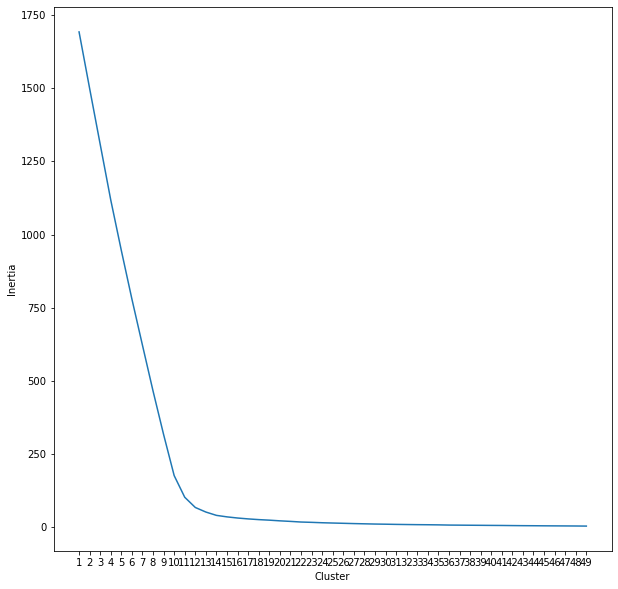

In [19]:
utils.elbowPlot(range(1,50), df_pca)

The plot shows the elbow at about 11 or 12 clusters, indicating a suitable k value for k-means clustering:

<a id="1.1"></a>
### 1.1 K-Means on Annotated Text Spans

*Note: also tried 3 (number of annotation categories) and 9 (number of annotation labels) as k values but no more meaningful clusters seemed to appear.*

In [20]:
kmeans = KMeans(n_clusters=12, random_state=22)
annots_clusters = kmeans.fit_predict(df_pca)
df_clustered = df.copy()
df_clustered.insert(len(df_clustered.columns), "cluster", annots_clusters)

In [23]:
df_clustered.groupby("cluster").size().reset_index(name="count")

,cluster,count
0,0,53025
1,1,194
2,2,203
3,3,176
4,4,164
5,5,181
6,6,192
7,7,189
8,8,160
9,9,191


We have one very large cluster (0) and many other smaller clusters (1-11).

Let's investigate the large cluster:

In [62]:
for n in range(11):
    print("Cluster {}:".format(n))
    print(df_clustered.loc[df_clustered.cluster == n].label.value_counts())
    print(df_clustered.loc[df_clustered.cluster == n].category.value_counts())
    print(df_clustered.loc[df_clustered.cluster == n].associated_genders.value_counts())
    print()

Cluster 0:
Unknown             22218
Omission             7425
Masculine            5934
Gendered-Pronoun     4171
Occupation           4045
Gendered-Role        3590
Stereotype           2594
Generalization       2054
Feminine             1738
Name: label, dtype: int64
Person-Name    29890
Contextual     14064
Linguistic      9815
Name: category, dtype: int64
Unclear      40894
Masculine     8654
Multiple      2664
Feminine      1557
Name: associated_genders, dtype: int64

Cluster 1:
Unknown    194
Name: label, dtype: int64
Person-Name    194
Name: category, dtype: int64
Unclear    194
Name: associated_genders, dtype: int64

Cluster 2:
Unknown    192
Name: label, dtype: int64
Person-Name    192
Name: category, dtype: int64
Unclear    192
Name: associated_genders, dtype: int64

Cluster 3:
Unknown    203
Name: label, dtype: int64
Person-Name    203
Name: category, dtype: int64
Unclear    203
Name: associated_genders, dtype: int64

Cluster 4:
Unknown           64
Stereotype        50
Omi

The summary data of the large cluster seems to roughly reflect the summary of the overall dataset.  What about the text entries?

In [31]:
for n in range(12):
    print("Cluster {}:".format(n), len(df_clustered.loc[df_clustered.cluster == n].text.unique()))

Cluster 0: 13966
Cluster 1: 4
Cluster 2: 10
Cluster 3: 6
Cluster 4: 51
Cluster 5: 89
Cluster 6: 4
Cluster 7: 78
Cluster 8: 24
Cluster 9: 122
Cluster 10: 95
Cluster 11: 86


Cluster 0 has 96% of the overall dataset's 14535 unique text entries!

In [37]:
text0 = list(df_clustered.loc[df_clustered.cluster == 0].text.unique())
print(text0[:100])

['knighted', 'knighthood', 'Prince Regent', 'Sir', 'Knighthood', 'Mrs Norman Macleod', 'Messrs', 'Negrette', 'Women', 'Woman', 'Dr. Nelly Renee Deme', 'Marjory Kennedy-Fraser', 'Marjory Kennedy Fraser', 'Marjory Kennedy', 'McNeill', 'Kennedy', 'Hood, Helen Patuffa', 'Patuffa Kennedy-Fraser', 'Yolanda', 'William Temple', 'John Baillie', 'Cyril Forster Garbett', 'Dr Fraps', 'J.E Wilson', 'Major MacDougall', 'Professor I. Michael Lerner', 'Florence Jewel Baillie (nee Fowler)', 'Annie Baillie (nee Macpherson)', 'Jeannie (Jane Mary) MacColl', 'Miss Drummond', 'Helen P. Kennedy-Fraser', 'Fraser, Marjory Kennedy-', 'Mrs Fraps', 'Estelle Sylvia Pankhurst', 'Adela Pankhurst', 'Rathbone, Eleanor', 'Billy Graham', 'Sir Walter Scott', 'Aquinas', 'John', 'Donald Macpherson Baillie', 'John Templeton', 'Mr Kennedy', 'Granville Bantock', 'Duncan Weatherstone', 'Professor Alex Robertson', 'Mr Glen', 'Alan Greenwood', 'Monsieur Pidange', 'Wallace', 'Honourable Guy Wilson', 'Captain and Lieutenant Bardwe

In [39]:
df0 = df_clustered.loc[df_clustered.cluster == 0]
non_pn_text0 = list(df0.loc[df0.category != "Person-Name"].text.unique())
print(non_pn_text0[:100])

['knighted', 'knighthood', 'Prince Regent', 'Sir', 'Knighthood', 'Messrs', 'Negrette', 'Women', 'Woman', 'Husband', 'Raja', 'His', 'two boys, one girl', 'daughter of the Rev. J. S. Whale', 'his wife', "farmer's wife", 'daughter of Isaac Taylor', 'men', 'Man', 'mother', 'father', 'son', 'His second wife', 'David H. Stam was married', 'His wife', 'his daughter Maria', 'unidentified man', 'unidentified man and woman', 'unidentified woman', 'three men', 'a man', 'an Indian man', 'a group of Englishmen', 'four men', 'a woman', 'the men', 'two Indian men', 'One man', 'six other men', 'woman', 'six men', 'a little girl', 'another man', 'a Western man', 'two African men', 'two Egyptian women', 'two Maori men', 'two boys', 'a seated man', 'a Tamil man', 'three women', 'a Maori man', 'an unidentified man', 'three [Indian?] men', 'several Indian men', 'several men', 'an unknown man', 'one man', 'two other men', 'a boy', 'four African men', 'Indian men', 'two women', 'two Monda [Munda] women', 'tw

<a id="1.2"></a>
### 1.2 DBSCAN on Annotated Text Spans

In [ ]:
# utils.findOptimalEps(2, df_tfidf)  STOPPED HERE

In [ ]:
dbscan = DBSCAN(eps=, metric="euclidean")  # change to cosine distance if use TFIDF DataFrame
dbscan_clusters = dbscan.fit_predict(df_pca)
df_dbscan = df.copy()
df_dbscan.insert(len(df_dbscan.columns), "cluster", dbscan_clusters)
df_dbscan["cluster"].unique()